<hr style="height:2px;">

# Demo: Training data generation for BCM3D 2.0

This notebook demonstrates training data generation for a 3D image transfer task, where corresponding pairs of raw and intermediate image representation stacks can be acquired. 

In [8]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread, imwrite
from csbdeep.utils import plot_some
from csbdeep.data import RawData, create_patches
import os

<hr style="height:2px;">

# Input data

Input data consisting of raw and intermediate image representation 3D images bacterial biofilms.  
Note that raw data only have one channel, we will duplicate it to make its channel number equal to the intermediate image representation.

We can plot the training stack pair via maximum-projection:

In [9]:
y = imread('Data/Training/ImageRepresentation/1_SBR_1869_DR_0.9508_197_membrane.tif')
x = imread('Data/Training/Raw/1_SBR_1869_DR_0.9508_197_membrane.tif')
print('image size =', y.shape)
print('image size =', x.shape)

image size = (80, 2, 200, 200)
image size = (80, 200, 200)


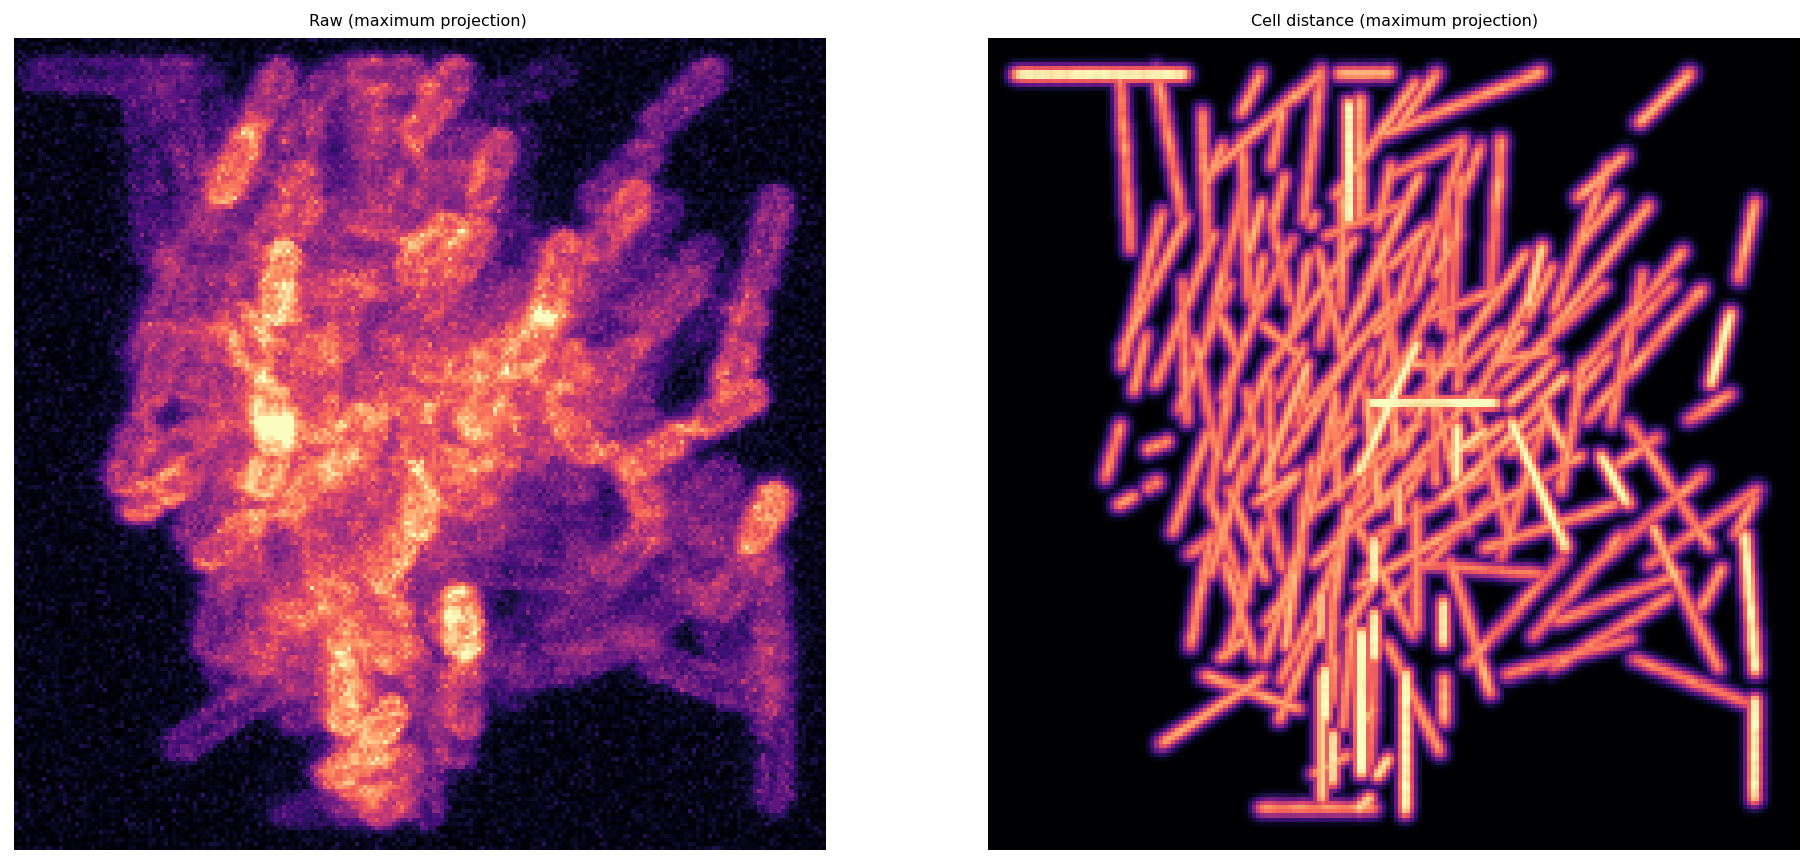

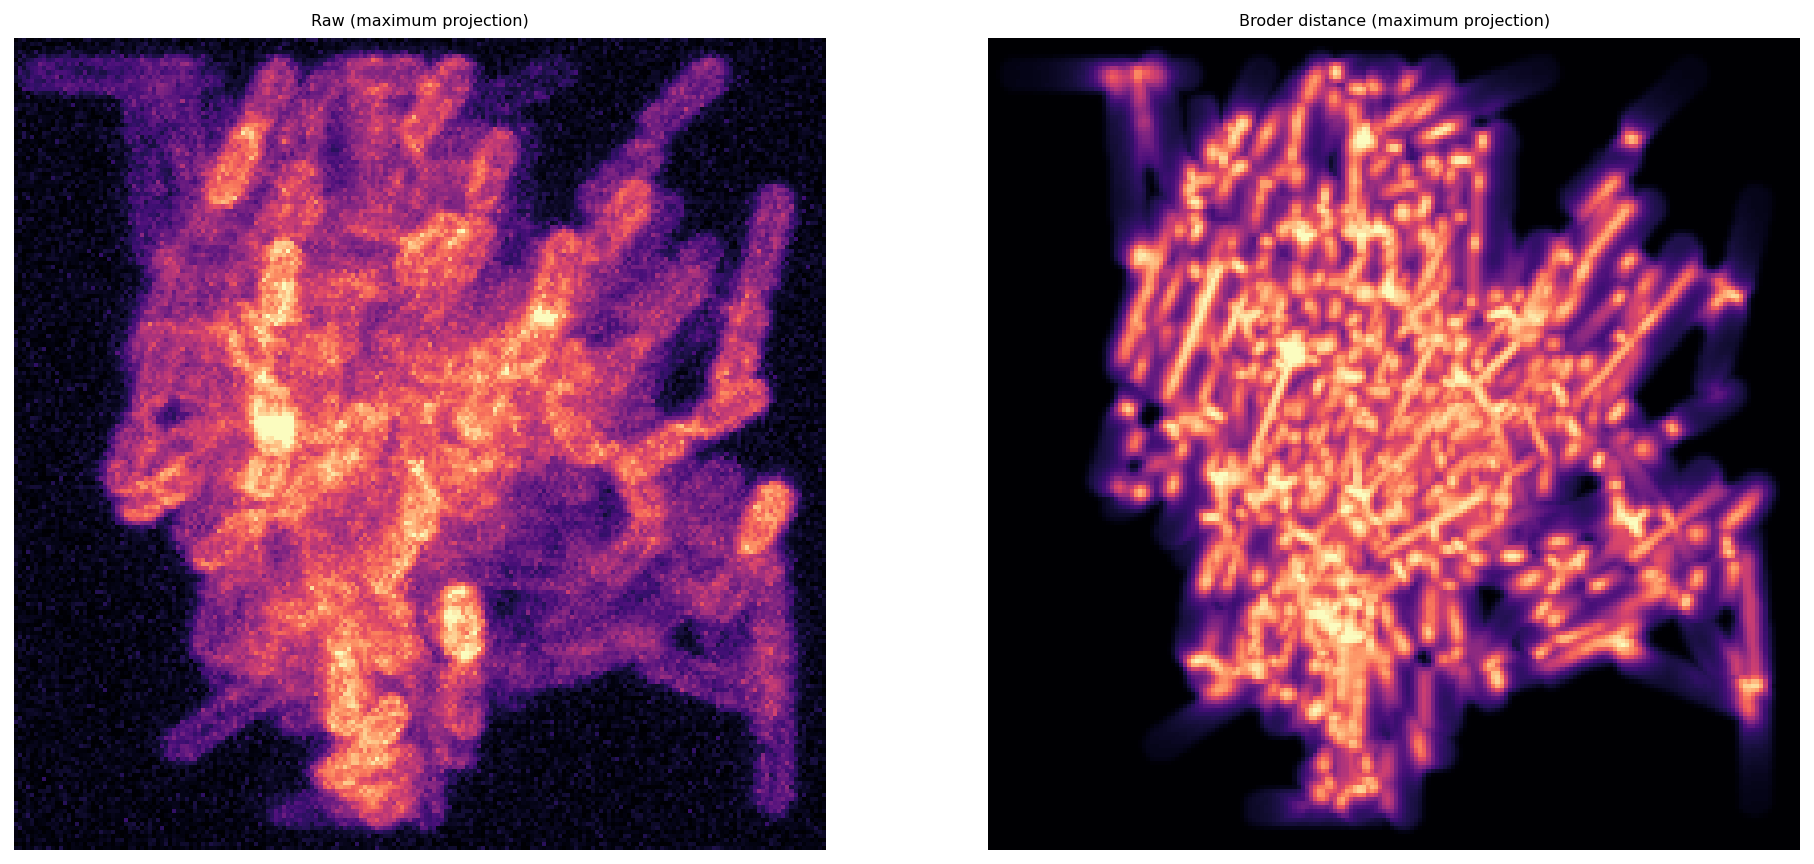

In [10]:
plt.figure(figsize=(16,10))
plot_some(np.stack([x,y[:,0,:,:]]),
          title_list=[['Raw (maximum projection) ','Cell distance (maximum projection)']], 
          pmin=2,pmax=99.8);
plt.figure(figsize=(16,10))
plot_some(np.stack([x,y[:,1,:,:]]),
          title_list=[['Raw (maximum projection)','Broder distance (maximum projection)']], 
          pmin=2,pmax=99.8);

We duplicate and concatenate the raw data to make its channel equal to the intermediate image representation:

In [12]:
rawstacks = []
rawfilenames = []


folder1 = 'Raw'
for rawfilename in os.listdir(folder1):#import raw data folder
    if rawfilename.endswith('.tif'):
        rawstack = imread(os.path.join(folder1, rawfilename))
        if rawstack is not None:
            rawstacks.append(rawstack)
            rawfilenames.append(rawfilename)
            
num = len(rawstacks)

for i in range(num):
    raw = rawstacks[i]
    input_stack = np.stack((raw, raw),axis=-1)
    input_stack = np.moveaxis(input_stack, [0,1,2,3], [-4,-2,-1,-3]) #axis need to be ('ZCXY')
    dir = os.path.join('Data/Training/','TrainingRaw')
    if not os.path.exists(dir):
        os.mkdir(dir)
    filename = rawfilenames[i]
    filename = os.path.join(dir, filename)
    imwrite(filename, input_stack, imagej=True, metadata={'axes': 'ZCYX'})

<hr style="height:2px;">

# Generate training data for BCM3D 2.0 training

We first need to create a `RawData` object, which defines how to get the pairs of Raw/ImageRepresentation stacks.

Here we have two folders "TrainingRaw" and "ImageRepresentation", where corresponding Raw (After duplicate and concatenate) and ImageRepresentation stacks are TIF images with identical filenames.  
For this case, we can simply use `RawData.from_folder` and set `axes = 'ZCYX'` to indicate the semantic order of the image axes. 

In [14]:
raw_data = RawData.from_folder (
    basepath    = 'training/',
    source_dirs = ['TrainingRaw'],
    target_dir  = 'ImageRepresentation',
    axes        = 'ZCYX',
)

From corresponding stacks, we now generate some 3D patches. As a general rule, use a patch size that is a power of two along XYZ, or at least divisible by 8.  

In [15]:
X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (32,2,64,64),
    n_patches_per_image = 256,
    save_file           = 'Data/Training/training_data.npz',
)

   10 raw images x    1 transformations   =    10 images
   10 images     x  256 patches per image =  2560 patches in total
Input data:
E:/Cell&broder_dist/Residual/: target='Outputcrop', sources=['Input'], axes='ZCYX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
32 x 2 x 64 x 64


C:\Users\GahlmannLab\anaconda3\envs\CSBdeep\lib\site-packages\csbdeep\data\generate.py:303: RuntimeWarning: overflow encountered in long_scalars
  n_required_memory_bytes = 2 * n_patches*np.prod(patch_size) * 4
100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


Saving data to E:\Cell&broder_dist\Residual\training_data.npz.


In [16]:
assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", XY_axes)

shape of X,Y = (2560, 2, 32, 64, 64)
axes  of X,Y = SCZYX


## Show

This shows the maximum projection of some of the generated patch pairs (odd rows: *source*, even rows: *target*)

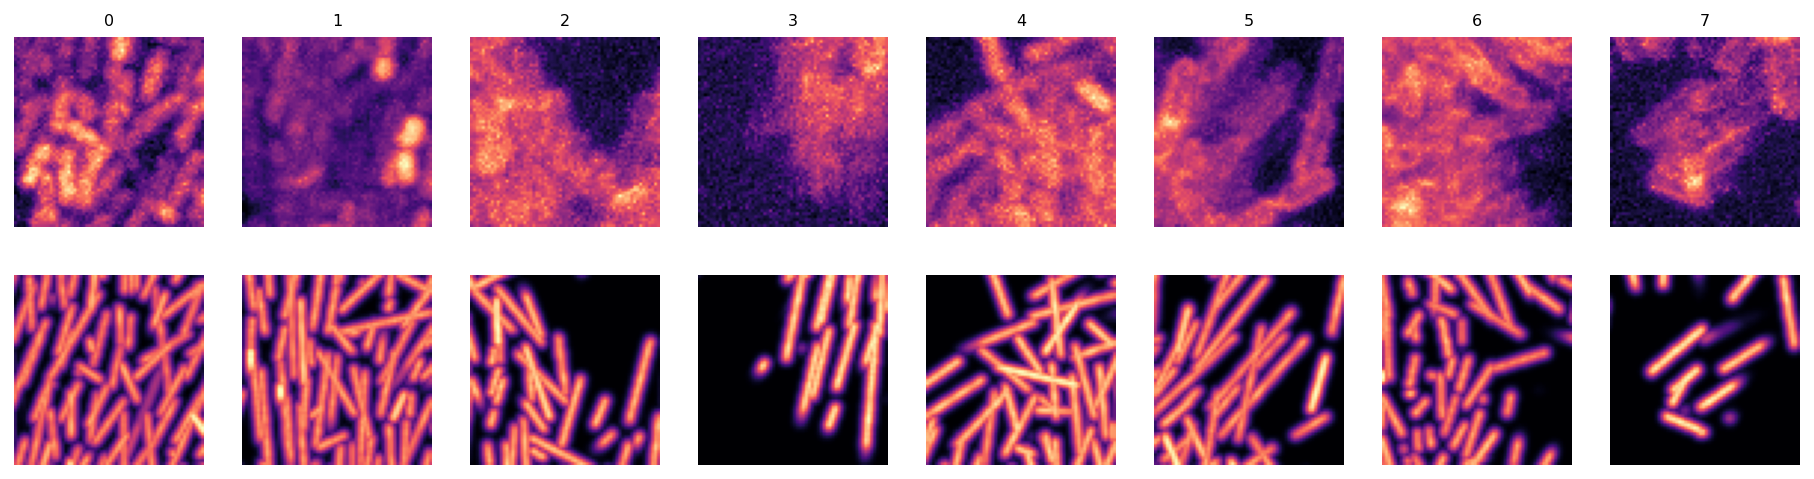

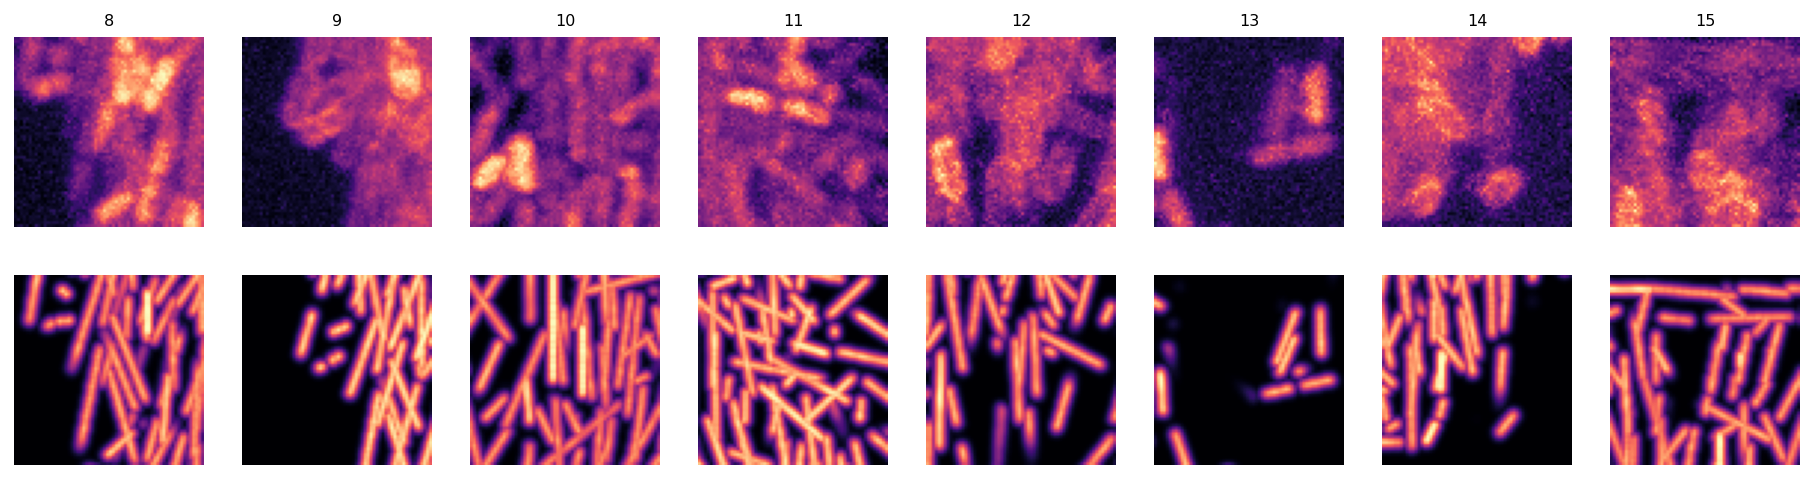

In [17]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;